In [1]:
# Run this cell to mount your Google Drive.

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Imports

In [ ]:
!pip install rlcard
!pip install rlcard[torch]
!pip install rlcard[tensorflow]

In [3]:
# path
pth = '/content/drive/MyDrive/Colab Notebooks/Thesis'

%cd /content/drive/My Drive/Colab Notebooks/Thesis/SupervisedLearning

from models import *

# %cd /content/drive/My Drive/Colab Notebooks/Thesis/dqn

# import DQNAgent_pytorch as DQNAgent

%cd /content/drive/My Drive/Colab Notebooks/Thesis

/content/drive/My Drive/Colab Notebooks/Thesis/SupervisedLearning
/content/drive/My Drive/Colab Notebooks/Thesis


## DQN Customized

In [4]:
''' DQN agent
The code was adapted from RLCard from https://github.com/datamllab/rlcard/blob/master/rlcard/agents/dqn_agent_pytorch.py
The code is derived from https://github.com/dennybritz/reinforcement-learning/blob/master/DQN/dqn.py
Copyright (c) 2019 Matthew Judell
Copyright (c) 2019 DATA Lab at Texas A&M University
Copyright (c) 2016 Denny Britz
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
'''

import numpy as np
import torch
import torch.nn as nn
from collections import namedtuple
from copy import deepcopy

from rlcard.agents.dqn_agent import Memory
from rlcard.utils.utils import remove_illegal

Transition = namedtuple('Transition', ['state', 'action', 'reward', 'next_state', 'done'])


class DQNAgent(object):
    '''
    Approximate clone of rlcard.agents.dqn_agent.DQNAgent
    that depends on PyTorch instead of Tensorflow
    '''
    def __init__(self,
                 scope,
                 replay_memory_size=20000,
                 replay_memory_init_size=100,
                 update_target_estimator_every=1000,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=32,
                 action_num=2,
                 state_shape=None,
                 train_every=1,
                 mlp_layers=None,
                 learning_rate=0.00005,
                 device=None):

        '''
        Q-Learning algorithm for off-policy TD control using Function Approximation.
        Finds the optimal greedy policy while following an epsilon-greedy policy.
        Args:
            scope (str): The name of the DQN agent
            replay_memory_size (int): Size of the replay memory
            replay_memory_init_size (int): Number of random experiences to sampel when initializing
              the reply memory.
            update_target_estimator_every (int): Copy parameters from the Q estimator to the
              target estimator every N steps
            discount_factor (float): Gamma discount factor
            epsilon_start (int): Chance to sample a random action when taking an action.
              Epsilon is decayed over time and this is the start value
            epsilon_end (int): The final minimum value of epsilon after decaying is done
            epsilon_decay_steps (int): Number of steps to decay epsilon over
            batch_size (int): Size of batches to sample from the replay memory
            evaluate_every (int): Evaluate every N steps
            action_num (int): The number of the actions
            state_space (list): The space of the state vector
            train_every (int): Train the network every X steps.
            mlp_layers (list): The layer number and the dimension of each layer in MLP
            learning_rate (float): The learning rate of the DQN agent.
            device (torch.device): whether to use the cpu or gpu
        '''
        self.use_raw = False
        self.scope = scope
        self.replay_memory_init_size = replay_memory_init_size
        self.update_target_estimator_every = update_target_estimator_every
        self.discount_factor = discount_factor
        self.epsilon_decay_steps = epsilon_decay_steps
        self.batch_size = batch_size
        self.action_num = action_num
        self.train_every = train_every

        # Torch device
        if device is None:
            self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device

        # Total timesteps
        self.total_t = 0

        # Total training step
        self.train_t = 0

        # The epsilon decay scheduler
        self.epsilons = np.linspace(epsilon_start, epsilon_end, epsilon_decay_steps)

        # Create estimators
        self.q_estimator = Estimator(action_num=action_num, learning_rate=learning_rate, state_shape=state_shape, \
            mlp_layers=mlp_layers, device=self.device)
        self.target_estimator = Estimator(action_num=action_num, learning_rate=learning_rate, state_shape=state_shape, \
            mlp_layers=mlp_layers, device=self.device)

        # Create replay memory
        self.memory = Memory(replay_memory_size, batch_size)

    def feed(self, ts):
        ''' Store data in to replay buffer and train the agent. There are two stages.
            In stage 1, populate the memory without training
            In stage 2, train the agent every several timesteps
        Args:
            ts (list): a list of 5 elements that represent the transition
        '''
        (state, action, reward, next_state, done) = tuple(ts)
        self.feed_memory(state['obs'], action, reward, next_state['obs'], done)
        self.total_t += 1
        tmp = self.total_t - self.replay_memory_init_size
        if tmp>=0 and tmp%self.train_every == 0:
            self.train()

    def step(self, state):
        ''' Predict the action for genrating training data but
            have the predictions disconnected from the computation graph
        Args:
            state (numpy.array): current state
        Returns:
            action (int): an action id
        '''
        A = self.predict(state['obs'])
        A = remove_illegal(A, state['legal_actions'])
        action = np.random.choice(np.arange(len(A)), p=A)
        return action

    def eval_step(self, state):
        ''' Predict the action for evaluation purpose.
        Args:
            state (numpy.array): current state
        Returns:
            action (int): an action id
        '''
        q_values = self.q_estimator.predict_nograd(np.expand_dims(state['obs'], 0))[0]
        probs = remove_illegal(np.exp(q_values), state['legal_actions'])
        best_action = np.argmax(probs)
        return best_action, probs

    def predict(self, state):
        ''' Predict the action probabilities but have them
            disconnected from the computation graph
        Args:
            state (numpy.array): current state
        Returns:
            q_values (numpy.array): a 1-d array where each entry represents a Q value
        '''
        epsilon = self.epsilons[min(self.total_t, self.epsilon_decay_steps-1)]
        A = np.ones(self.action_num, dtype=float) * epsilon / self.action_num
        q_values = self.q_estimator.predict_nograd(np.expand_dims(state, 0))[0]
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A

    def train(self):
        ''' Train the network
        Returns:
            loss (float): The loss of the current batch.
        '''
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample()

        # Calculate best next actions using Q-network (Double DQN)
        q_values_next = self.q_estimator.predict_nograd(next_state_batch)
        best_actions = np.argmax(q_values_next, axis=1)

        # Evaluate best next actions using Target-network (Double DQN)
        q_values_next_target = self.target_estimator.predict_nograd(next_state_batch)
        target_batch = reward_batch + np.invert(done_batch).astype(np.float32) * \
            self.discount_factor * q_values_next_target[np.arange(self.batch_size), best_actions]

        # Perform gradient descent update
        state_batch = np.array(state_batch)

        loss = self.q_estimator.update(state_batch, action_batch, target_batch)
        print('\rINFO - Agent {}, step {}, rl-loss: {}'.format(self.scope, self.total_t, loss), end='')

        # Update the target estimator
        if self.train_t % self.update_target_estimator_every == 0:
            self.target_estimator = deepcopy(self.q_estimator)
            print("\nINFO - Copied model parameters to target network.")

        self.train_t += 1

    def feed_memory(self, state, action, reward, next_state, done):
        ''' Feed transition to memory
        Args:
            state (numpy.array): the current state
            action (int): the performed action ID
            reward (float): the reward received
            next_state (numpy.array): the next state after performing the action
            done (boolean): whether the episode is finished
        '''
        self.memory.save(state, action, reward, next_state, done)

    def get_state_dict(self):
        ''' Get the state dict to save models
        Returns:
            (dict): A dict of model states
        '''
        q_key = self.scope + '_q_estimator'
        q_value = self.q_estimator.qnet.state_dict()
        target_key = self.scope + '_target_estimator'
        target_value = self.target_estimator.qnet.state_dict()
        return {q_key: q_value, target_key: target_value}

    def load(self, checkpoint):
        ''' Load model
        Args:
            checkpoint (dict): the loaded state
        '''
        q_key = self.scope + '_q_estimator'
        self.q_estimator.qnet.load_state_dict(checkpoint[q_key])
        target_key = self.scope + '_target_estimator'
        self.target_estimator.qnet.load_state_dict(checkpoint[target_key])

class Estimator(object):
    '''
    Approximate clone of rlcard.agents.dqn_agent.Estimator that
    uses PyTorch instead of Tensorflow.  All methods input/output np.ndarray.
    Q-Value Estimator neural network.
    This network is used for both the Q-Network and the Target Network.
    '''

    def __init__(self, action_num=2, learning_rate=0.001, state_shape=None, mlp_layers=None, device=None):
        ''' Initilalize an Estimator object.
        Args:
            action_num (int): the number output actions
            state_shape (list): the shape of the state space
            mlp_layers (list): size of outputs of mlp layers
            device (torch.device): whether to use cpu or gpu
        '''
        self.action_num = action_num
        self.learning_rate=learning_rate
        self.state_shape = state_shape
        self.mlp_layers = mlp_layers
        self.device = device

        # set up Q model and place it in eval mode
        qnet = EstimatorNetwork(action_num, state_shape, mlp_layers)
        qnet = qnet.to(self.device)
        self.qnet = qnet
        self.qnet.eval()

        # initialize the weights using Xavier init
        for p in self.qnet.parameters():
            if len(p.data.shape) > 1:
                nn.init.xavier_uniform_(p.data)

        # set up loss function
        self.mse_loss = nn.MSELoss(reduction='mean')

        # set up optimizer
        self.optimizer =  torch.optim.Adam(self.qnet.parameters(), lr=self.learning_rate)

    def predict_nograd(self, s):
        ''' Predicts action values, but prediction is not included
            in the computation graph.  It is used to predict optimal next
            actions in the Double-DQN algorithm.
        Args:
          s (np.ndarray): (batch, state_len)
        Returns:
          np.ndarray of shape (batch_size, NUM_VALID_ACTIONS) containing the estimated
          action values.
        '''
        with torch.no_grad():
            s = torch.from_numpy(s).float().to(self.device)
            q_as = self.qnet(s).cpu().numpy()
        return q_as

    def update(self, s, a, y):
        ''' Updates the estimator towards the given targets.
            In this case y is the target-network estimated
            value of the Q-network optimal actions, which
            is labeled y in Algorithm 1 of Minh et al. (2015)
        Args:
          s (np.ndarray): (batch, state_shape) state representation
          a (np.ndarray): (batch,) integer sampled actions
          y (np.ndarray): (batch,) value of optimal actions according to Q-target
        Returns:
          The calculated loss on the batch.
        '''
        self.optimizer.zero_grad()

        self.qnet.train()

        s = torch.from_numpy(s).float().to(self.device)
        a = torch.from_numpy(a).long().to(self.device)
        y = torch.from_numpy(y).float().to(self.device)

        # (batch, state_shape) -> (batch, action_num)
        q_as = self.qnet(s)

        # (batch, action_num) -> (batch, )
        Q = torch.gather(q_as, dim=-1, index=a.unsqueeze(-1)).squeeze(-1)

        # update model
        batch_loss = self.mse_loss(Q, y)
        batch_loss.backward()
        self.optimizer.step()
        batch_loss = batch_loss.item()

        self.qnet.eval()

        return batch_loss


class EstimatorNetwork(nn.Module):
    ''' The function approximation network for Estimator
        It is just a series of sigmoid layers. All in/out are torch.tensor
        (OLD) It is just a series of tanh layers. All in/out are torch.tensor
    '''

    def __init__(self, action_num=2, state_shape=None, mlp_layers=None):
        ''' Initialize the Q network
        Args:
            action_num (int): number of legal actions
            state_shape (list): shape of state tensor
            mlp_layers (list): output size of each fc layer
        '''
        super(EstimatorNetwork, self).__init__()

        self.action_num = action_num
        self.state_shape = state_shape
        self.mlp_layers = mlp_layers

        # build the Q network
        layer_dims = [np.prod(self.state_shape)] + self.mlp_layers
        fc = [nn.Flatten()]
        # fc.append(nn.BatchNorm1d(layer_dims[0]))
        for i in range(len(layer_dims)-1):
            fc.append(nn.Linear(layer_dims[i], layer_dims[i+1], bias=True))
            fc.append(nn.Sigmoid())
        fc.append(nn.Linear(layer_dims[-1], self.action_num, bias=True))
        fc.append(nn.Softmax(dim=1))
        self.fc_layers = nn.Sequential(*fc)

    def forward(self, s):
        ''' Predict action values
        Args:
            s  (Tensor): (batch, state_shape)
        '''
        return self.fc_layers(s)

## Run

In [7]:
from tensorflow.keras.backend import clear_session
clear_session()

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False

----------------------------------------
  timestep     |  136
  reward       |  0.20679999999999968
----------------------------------------
INFO - Agent dqn, step 1000, rl-loss: 0.34822678565979004
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 2000, rl-loss: 0.5819202661514282
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 3000, rl-loss: 0.5173667073249817
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 4000, rl-loss: 0.37212714552879333
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 4484, rl-loss: 0.4371311664581299
--------------------------

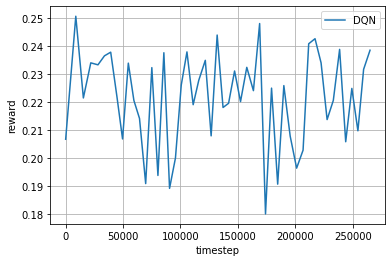

In [9]:
import torch
import tensorflow
import os

import rlcard
# from rlcard.agents import DQNAgentPytorch as DQNAgent
from rlcard.agents import RandomAgent
from rlcard.utils import set_global_seed, tournament
from rlcard.utils import Logger

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Make environment
env = rlcard.make('gin-rummy', config={'seed': 0})
eval_env = rlcard.make('gin-rummy', config={'seed': 0})
env.game.settings.print_settings()

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 5000  # mahjong_dqn has 100000
# episode_num = 1000  # mahjong_dqn has 100000

# The initial memory size
memory_init_size = 1000

# Train the agent every X steps
train_every = 1

# The paths for saving the logs and learning curves
log_dir = './experiments/gin_rummy_dqn_result/all/all/all_states_all_actions_2hl_extra_knock_data_40K'

# Set a global seed
set_global_seed(0)

agent = DQNAgent(scope='dqn',
                 action_num=env.action_num,
                 replay_memory_init_size=memory_init_size,
                 train_every=train_every,
                 state_shape=env.state_shape,
                 mlp_layers=[520, 110],
                 device=device)
    # def __init__(self,
    #              scope,
    #              replay_memory_size=20000,
    #              replay_memory_init_size=100,
    #              update_target_estimator_every=1000,
    #              discount_factor=0.99,
    #              epsilon_start=1.0,
    #              epsilon_end=0.1,
    #              epsilon_decay_steps=20000,
    #              batch_size=32,
    #              action_num=2,
    #              state_shape=None,
    #              train_every=1,
    #              mlp_layers=None,
    #              learning_rate=0.00005,
    #              device=None)

state = 'all'
action = 'all'
model = torch.load('{}/models/{}/{}/all_states_all_actions_2hl_extra_knock_data_40K/model.pt'.format(pth,state,action), map_location=device)

# load pretrained weights
agent.q_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
agent.q_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
agent.q_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
agent.q_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)
agent.q_estimator.qnet.fc_layers[5].weight = torch.nn.Parameter(model.l3.weight)
agent.q_estimator.qnet.fc_layers[5].bias = torch.nn.Parameter(model.l3.bias)

agent.target_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
agent.target_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
agent.target_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
agent.target_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)
agent.target_estimator.qnet.fc_layers[5].weight = torch.nn.Parameter(model.l2.weight)
agent.target_estimator.qnet.fc_layers[5].bias = torch.nn.Parameter(model.l2.bias)
# agent.q_estimator.qnet.fc_layers[2].weight = torch.nn.Parameter(model.l1.weight)
# agent.q_estimator.qnet.fc_layers[2].bias = torch.nn.Parameter(model.l1.bias)
# agent.q_estimator.qnet.fc_layers[4].weight = torch.nn.Parameter(model.l2.weight)
# agent.q_estimator.qnet.fc_layers[4].bias = torch.nn.Parameter(model.l2.bias)
# agent.q_estimator.qnet.fc_layers[6].weight = torch.nn.Parameter(model.l3.weight)
# agent.q_estimator.qnet.fc_layers[6].bias = torch.nn.Parameter(model.l3.bias)

# agent.target_estimator.qnet.fc_layers[2].weight = torch.nn.Parameter(model.l1.weight)
# agent.target_estimator.qnet.fc_layers[2].bias = torch.nn.Parameter(model.l1.bias)
# agent.target_estimator.qnet.fc_layers[4].weight = torch.nn.Parameter(model.l2.weight)
# agent.target_estimator.qnet.fc_layers[4].bias = torch.nn.Parameter(model.l2.bias)
# agent.target_estimator.qnet.fc_layers[6].weight = torch.nn.Parameter(model.l2.weight)
# agent.target_estimator.qnet.fc_layers[6].bias = torch.nn.Parameter(model.l2.bias)

random_agent = RandomAgent(action_num=eval_env.action_num)
env.set_agents([agent, random_agent])
eval_env.set_agents([agent, random_agent])

# Init a Logger to plot the learning curve
logger = Logger(log_dir)

for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance. Play with random agents.
    if episode % evaluate_every == 0:
        logger.log_performance(env.timestep, tournament(eval_env, evaluate_num)[0])

# Close files in the logger
logger.close_files()

# Plot the learning curve
logger.plot('DQN')

# Save model
save_dir = 'models/gin_rummy_dqn_pytorch/all/all/all_states_all_actions_2hl_extra_knock_data_40K'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
print(state_dict.keys())
torch.save(state_dict, os.path.join(save_dir, 'model.pth'))